In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import functional as VF
from torchmetrics.classification import BinaryJaccardIndex
from torchvision import models, datasets, tv_tensors
from torchvision.transforms import v2
import pandas as pd
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import random
import data_pipeline

In [58]:
import unet
import baseline
import json
# model = unet.UNet(n_channels=1, n_classes=1)
model = baseline.Baseline()
model.load_state_dict(torch.load('./checkpoints/baseline/baseline_model_4.pt', map_location=torch.device('cpu')))
test_df = data_pipeline.build_test_dataframe(use_processed_images=False, well_number=3)
train_df = data_pipeline.build_dataframe(use_processed_images=False, well_number=3)
X_test, X_names, X_train, Y_train = data_pipeline.build_test_dataloaders(test_df, train_df, apply_scaling=True)
test_dl = DataLoader(TensorDataset(X_test), batch_size=1)

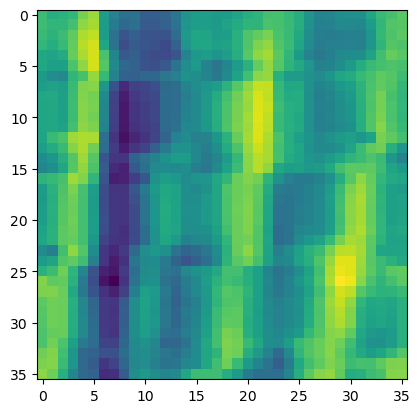

In [59]:
train_data = torch.from_numpy(np.vstack(train_df['data'].to_numpy()))
train_data = torch.nan_to_num(train_data)
plt.imshow(train_data[2].view(36, 36), norm=None)

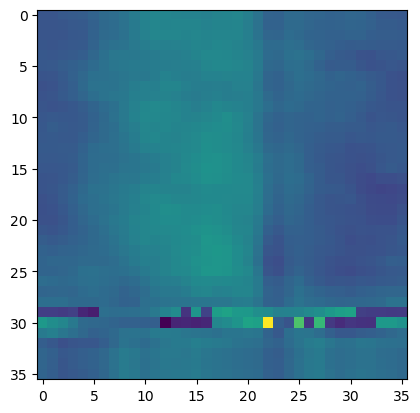

In [70]:
input_1 = X_train[0].reshape(36, 36)
plt.imshow(input_1, norm=None)

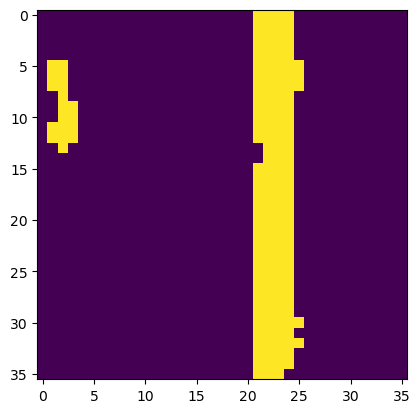

In [71]:
out_1 = model(X_train[0])
pred_1 = (out_1 > .5)*1.
plt.imshow(pred_1.reshape(36, 36))

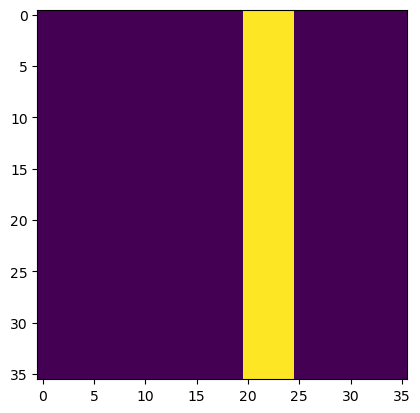

In [72]:
labels_1 = (Y_train[0]*1.).reshape(36, 36)
plt.imshow(labels_1)

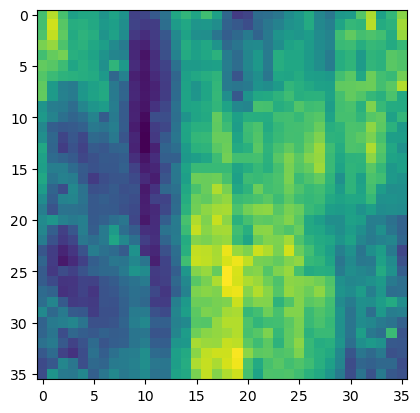

In [52]:
plt.imshow(test_df.iloc[0]['data'].reshape(36, 36))

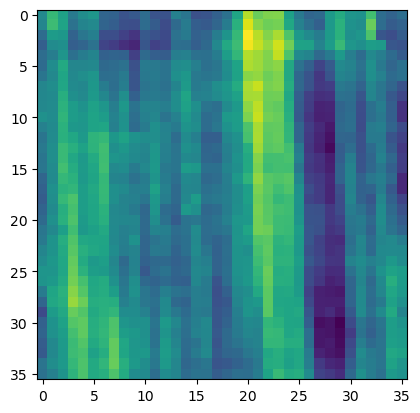

In [75]:
plt.imshow(X_test[1].reshape(36, 36))

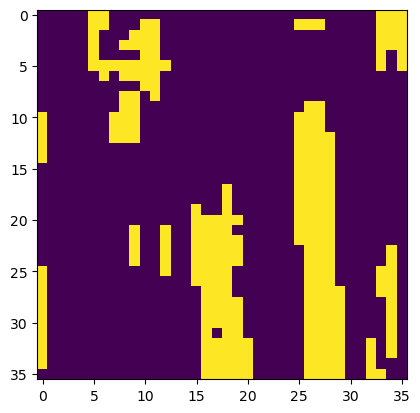

In [76]:
out_1 = model(X_test[1])
pred_1 = (out_1 > .5)*1.
plt.imshow(pred_1.reshape(36, 36))

In [37]:
predictions = {}
model.eval()
for index, x in tqdm(enumerate(test_dl)):
  out = model(x[0])
  preds = (F.sigmoid(out) > .5)*1.
  name = X_names[index][0]
  predictions[name] = preds.flatten().tolist()

330it [00:00, 330.17it/s]


In [38]:
preds_df = pd.DataFrame.from_dict(predictions, orient='index')

In [39]:
preds_df.to_csv('./outputs/KIRBY_predictions_well_3.csv')

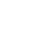

In [88]:
cols = [i for i in range(1296)]
VF.to_pil_image(torch.tensor(preds_df[cols].iloc[100].to_numpy().reshape(36, 36)))

# Pipe Prediction

In [10]:

def get_pipe_id_dataloaders(train_dataframe, valid_dataframe):
  data = torch.from_numpy(np.vstack(train_dataframe['data'].to_numpy()))
  data = torch.nan_to_num(data)
  labels = torch.from_numpy(np.vstack(train_dataframe['labels'].to_numpy()))

  valid_data = torch.from_numpy(np.vstack(valid_dataframe['data'].to_numpy()))
  valid_data = torch.nan_to_num(valid_data)
  valid_labels = torch.from_numpy(np.vstack(valid_dataframe['well_number'].to_numpy())).squeeze() - 1
  X_names = np.vstack(valid_dataframe['filename'].to_numpy())

  X_train, X_valid = data.float().reshape(-1, 1, 36, 36), valid_data.float().reshape(-1, 1, 36, 36)
  Y_train, Y_valid = labels, valid_labels

  return X_train, X_valid, Y_train, Y_valid, X_names

In [11]:
import pipe_identifier
import json

X_train, X_valid, Y_train, Y_valid, X_names = get_pipe_id_dataloaders(data_pipeline.build_dataframe(), data_pipeline.build_test_dataframe())
model = pipe_identifier.PipeIdentifier(num_classes=15)
model.load_state_dict(torch.load('./well_classifier_3.pt', map_location=torch.device('cpu')))


<All keys matched successfully>

In [12]:
pipe_id_dataloader = DataLoader(TensorDataset(X_valid), batch_size=1)

In [13]:
predictions = {}
model.eval()
for index, x in tqdm(enumerate(pipe_id_dataloader)):
  out = model(x[0])
  preds = torch.argmax(F.softmax(out, dim=1))
  name = X_names[index][0]
  predictions[name] = preds.flatten().tolist()

2538it [00:18, 139.39it/s]


In [14]:
preds_df = pd.DataFrame.from_dict(predictions, orient='index')

In [15]:
preds_df.value_counts()

12    2334
9       97
10      79
2       21
5        4
6        2
4        1
Name: count, dtype: int64

In [16]:
predictions = {}
model.eval()
for index, x in tqdm(enumerate(X_train)):
  out = model(x.unsqueeze(dim=0))
  preds = torch.argmax(F.softmax(out, dim=1))
  name = Y_train[index][0]
  predictions[name] = preds.flatten().tolist()

0it [00:00, ?it/s]

9670it [01:11, 135.99it/s]


In [20]:
preds_df = pd.DataFrame.from_dict(predictions, orient='index')
preds_df[0] += 1

In [21]:
preds_df.value_counts()

13    5081
3     2197
11    1517
7      438
10     190
2      162
6       74
1        8
15       2
9        1
Name: count, dtype: int64

# Performance so far


## Unets

- Unet 5  - 0.38 validation IoU - Two Down Convs + All Images Scaled + Bulk Augments
- Unet 8  - 0.64 validation IoU - Two Down Convs + No Scaling + Random Augments
- Unet 9  - 0.63 validation IoU - Three down convs + No Scaling + Random Augments
- Unet 10 - 0.57 validation IoU - One down conv + No Scaling + Random Augments


However on the test set our results are much worse. But it appears that the scaling does not make much of a difference

When looking at the output we are just predicting 0.0 for everything, and that is how we wind up with an unchanged score

- Unet 11 - 0.59 train IoU - Two Down Convs + No Scaling + Random Augments + No Train Test Split
  - predicts 481 total 1.0... probably not it either
- Unet 12 - 0.58 train IoU - Two Down Convs + Robust Scaler on full Train Set + Random Augments + No Train Test Split
  - predicts 3091 1.0 values, maybe this is the next one to test?
- Unet 13 - 0.66 train IoU - Full Unet + Robust Scaler on full Train Set + Random Augments + No Train Test Split
  - predicts 41 1.0 values... not it...


## Baselines

- We tested a baseline trained only on well 3 (baseline_4), and it succeeds in producing output that is not only one specific class. This demonstrates that on a single well, it is possible to implement the baseline. 